# ATC project: Pupil dilatation model 

Create a circular pupil model and check whether the created video makes sense. 

Pupil model will use tracking from DLC that includes: 
- tear
- wrikle
- eye_center
- eye12hs
- eye6hs
- eye3hs
- eye9hs
- eye1.30hs
- eye4.30hs
- eye7.30hs
- eye10.30hs

For pupil diameter we will use multiple measures:

- Mean from center to clock points.
- Distance between pair of opossite points. 

For exact position after sacades will use relative movement from center or artificial center (mean over clock) to teat and wrinkle.

Points in the tracking will be taken into consideration if they have an aceptable level of likelihood.

''' Oct 17th 2022'''


In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
from collections import namedtuple
import random
import scipy.signal as ssignal
from sklearn.linear_model import LinearRegression

### scale definition for converting pixel distance to cm diameter
npixel = 500
size = 400
pscale = size / npixel
frate = 30

### Thresholds for ethogram building
LIKELIHOOD_LIM = 0.9


In [305]:
## load tracking information
tracking_path = Path('/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/DLC_tracking/')
tracking_path.exists()
input_file_name = 'Basler_acA1920-155um__23267064__20201102_121214379DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv'
tracking_DFrame = pd.read_csv(tracking_path / input_file_name)

tracking_path ='/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/'
input_video_name = tracking_path + 'videos/Basler_acA1920-155um__23267064__20201102_121214379.mp4'
output_video = tracking_path + 'pupil_tracking_example.avi'

figures_path = '/home/melisamc/Documentos/ATC_project/figures/'


In [3]:
tracking_DFrame

,scorer,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.1,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.2,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.3,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.4,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.5,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.6,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.7,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.8,...,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.23,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.24,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.25,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.26,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.27,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.28,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.29,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.30,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.31,DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.32
0,bodyparts,tear,tear,tear,wrinkle,wrinkle,wrinkle,center,center,center,...,eye_1h30,eye_4h30,eye_4h30,eye_4h30,eye_7h30,eye_7h30,eye_7h30,eye_10h30,eye_10h30,eye_10h30
1,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,...,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
2,0,871.3253784179688,464.3075866699219,0.9798403978347778,1104.3651123046875,521.67529296875,0.9860265254974365,1000.5640258789062,472.3294677734375,0.9751606583595276,...,0.9867565631866455,1041.36181640625,506.92608642578125,0.971129298210144,958.0211791992188,509.1510314941406,0.9795297384262085,954.5994873046875,433.5188903808594,0.9828165769577026
3,1,871.1075439453125,463.80950927734375,0.9767483472824097,1103.2420654296875,522.77001953125,0.9822638034820557,1000.5187377929688,470.0498046875,0.9703446626663208,...,0.9831305742263794,1041.20361328125,506.7501220703125,0.9715620279312134,957.9067993164062,508.2833251953125,0.9735242128372192,954.3875732421875,432.5105285644531,0.980705201625824
4,2,870.0191650390625,462.3861389160156,0.9684432148933411,1104.3475341796875,520.1544189453125,0.9929497241973877,1001.8417358398438,468.83563232421875,0.9693872928619385,...,0.9746594429016113,1041.4910888671875,506.0909423828125,0.9706203937530518,958.8483276367188,507.16607666015625,0.947658896446228,954.9832153320312,430.5282897949219,0.9747298955917358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10536,10534,861.6387939453125,464.58392333984375,0.9716740250587463,1104.2178955078125,515.2672729492188,0.9738503694534302,976.1392822265625,458.3631591796875,0.9753682017326355,...,0.9886321425437927,1011.8541870117188,488.7350158691406,0.9855490922927856,944.7511596679688,486.8672790527344,0.9765722751617432,943.4288940429688,430.6686096191406,0.978644847869873
10537,10535,862.5553588867188,463.4789733886719,0.9676862955093384,1104.5562744140625,515.6869506835938,0.9793251752853394,976.3029174804688,458.61505126953125,0.9734304547309875,...,0.9889926314353943,1012.1359252929688,488.4415588378906,0.9864144325256348,944.1768188476562,485.9039306640625,0.9779801964759827,944.15869140625,430.0317077636719,0.9764366149902344
10538,10536,862.8719482421875,462.67938232421875,0.9656485915184021,1104.7559814453125,515.35791015625,0.9787787795066833,977.20654296875,458.03289794921875,0.9825537204742432,...,0.9879586696624756,1011.2353515625,488.59002685546875,0.9883524179458618,944.741455078125,484.9385986328125,0.9800105094909668,944.8836669921875,429.8543701171875,0.9769221544265747
10539,10537,862.6795654296875,463.5627136230469,0.9705761671066284,1104.7396240234375,515.6824340820312,0.9799515008926392,976.3432006835938,458.1340026855469,0.9824914336204529,...,0.9859662055969238,1010.4885864257812,488.08441162109375,0.9908158779144287,944.8322143554688,484.6521911621094,0.9818264245986938,945.4910888671875,430.4131774902344,0.9800276756286621


In [8]:
## get body parts from tracking fil
eye_parts = [tracking_DFrame.iloc[0][i*3+1] for i in range(int(len(tracking_DFrame.iloc[0])/3))]
eye_part_structure = [tracking_DFrame.iloc[1][i+1] for i in range(3)]

print(eye_part_structure)
tracking_DFrame = tracking_DFrame.iloc[0:]



['x', 'y', 'likelihood']


In [207]:
# convert tracking pandas to numpy
tracking_DFrame = tracking_DFrame.iloc[2:]
tracking_DFrame = tracking_DFrame.astype(float)
tracking_data = tracking_DFrame.to_numpy()
print(tracking_data.shape)
eye_tracking = tracking_data[:,1+2*3:];
tracking = np.array([eye_tracking[:,[i*3,i*3+1,i*3+2]] for i in range(9)])
print(tracking.shape)


(10496, 34)
(9, 10496, 3)


In [288]:
def center_model(position, likelihood_threshold = 0.5):
    
    center_position_model = np.zeros((2,))
    count = 0
    sum_x = 0
    sum_y = 0
    for i in range(8):
        if position[i,2] > likelihood_threshold:
            sum_x += position[i,0]
            sum_y += position[i,1]
            count+=1
    center_position_model[0] = sum_x / count
    center_position_model[1] = sum_y / count
    
    return center_position_model

def radius_model(position, center_position, likelihood_threshold, model_id):
    
    count = 0
    sum_rad = 0
    
    for i in range(8):
        if position[i,2] > likelihood_threshold:
            sum_rad += np.sqrt((position[i,0]-center_position[0])**2 + (position[i,1]-center_position[1])**2)
            count+=1

    return sum_rad / count

def shape_model(position, likelihood_threshold,model_id):
    
    '''
    Create a model circular model for pupil.
    
    input -> tracking: numpy array, contains positions along the eye. 
    Here we use the convetion for labeling: center,eye12,eye6,eye3,eye9,eye1.30,eye4.30,eye7.30,eye10.30.
    
    output -> shape : tupple, that contains the model for radius and center
    
    '''
    #center_value
    center_data = np.zeros((2,))
    center_m = center_model(position[1:,:],likelihood_threshold)

    if position[0,2] > likelihood_threshold:
        center_data[0] = position[0,0]
        center_data[1] = position[0,1]
    else:
        center_data = center_m
        
    
    radius_1 = radius_model(position[1:,:], center_data, likelihood_threshold,model_id)
    radius_2 = radius_model(position[1:,:], center_m, likelihood_threshold,model_id)

    shape = namedtuple('shape', ['center','center_model','radius'])
    
    return shape(center_data , center_m, radius_1)

def pupil_model(tracking = None, model_id = 0, likelihood_threshold = 0.8):
    
    '''
    Create a circular model for pupil shape, dilatation. 
    Different version refer to the data that will be use to create the model.
    
    
    input -> tracking : tracking of a 9 positions of the eye
             model_id: version of model to create the pupil:
             0 : mean over radius positions from center
             1 : mean over diameter positions
             
    
    output -> pupil_model: model of the mouse movement in time, that conteins center position and radius.
            center position is recomputed by using the tracking of the 8 points sorrounding the pupil
    
    '''
    model = [shape_model(tracking[:,i,:],model_id,likelihood_threshold) for i in range(tracking.shape[1])]
        
    pupil_model = namedtuple('pupil_model', ['shape_model'])
       
    return pupil_model(model)

### Create a video with the model
import cv2
NTIME = 5000
def create_pupil_dilatation_video(input_video_file, output_video_file,model1):
    
    cap = cv2.VideoCapture(str(input_video_name))
    #cap.set(cv2.CAP_PROP_POS_FRAMES, )
    w = int(video_in.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(video_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
    length = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #fourcc = cv.VideoWriter_fourcc('m', 'p', '4', 'v')
    #writer = cv.VideoWriter(file_path, fourcc, fps, (w, h))
    output = cv2.VideoWriter(str(output_video),cv2.VideoWriter_fourcc(*'MJPG'),20,(w,h))

    center = [model1.shape_model[frame_n].center.astype(int) for frame_n in range(len(model1.shape_model))]

    offset = length - len(center)

    for frame_n in range(length-offset):

        r , frame = cap.read()    
        if frame_n > offset:
            center1 = model1.shape_model[frame_n-offset].center.astype(int)
            radius1 = model1.shape_model[frame_n-offset].radius.astype(int) 
            cv2.circle(frame, tuple(center1),radius1, color = (255,0,0), thickness = 3)
        
        
        output.write(frame)
    
    return

In [289]:
pupil_model_radius = pupil_model(tracking)


In [293]:
print(input_video_name)
print(output_video)
create_pupil_dilatation_video(input_video_name, output_video,pupil_model_radius)

/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/videos/Basler_acA1920-155um__23267064__20201102_121214379.mp4
/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/pupil_tracking_example.avi


In [294]:
center1 = [pupil_model_radius.shape_model[frame_n].center for frame_n in range(len(pupil_model_radius.shape_model))]
radius = [pupil_model_radius.shape_model[frame_n].radius for frame_n in range(len(pupil_model_radius.shape_model))]

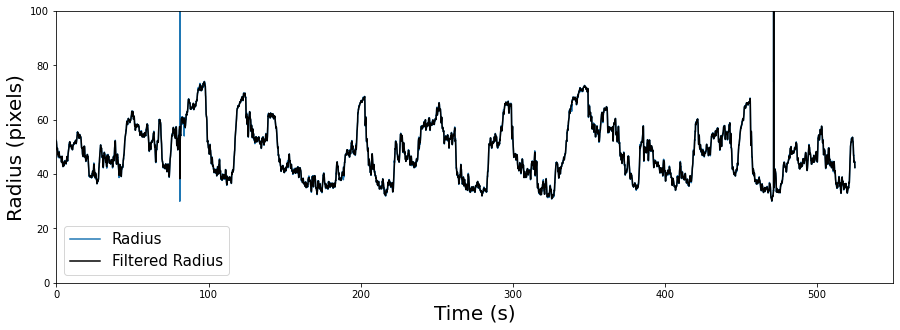

In [306]:
figure, axes = plt.subplots()
time = np.arange(0,len(radius))/20
smothed_radius = ssignal.medfilt(radius,3)

axes.plot(time,radius)
axes.plot(time,smothed_radius,c = 'k')

axes.set_xlim([0,550])
axes.set_ylim([0,100])

axes.set_xlabel('Time (s)', fontsize = 20)
axes.set_ylabel('Radius (pixels)', fontsize = 20)

axes.legend(['Radius','Filtered Radius'],fontsize = 15)
figure.set_size_inches([15,5])
figure.savefig(figures_path + 'radius_A04.png')